# Plot figures of supplementary materials

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../data/" directory

import os
import os.path as osp
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Embedding Visualization

In [2]:
label_map = {0: 'Static', 1: 'Decay', 2: 'Growth'}

In [3]:
label_map

{0: 'Static', 1: 'Decay', 2: 'Growth'}

In [88]:
models=['gcn','gin','pdglstm_ARI','pdglstm_TB','pdglstm_ARITB']
names = ['GCN','GIN','DDF_ARI','DDF_TB','DDF_ARI_TB']

In [268]:
idx = 0
model = models[idx]

In [269]:
import os
import os.path as osp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
import umap
from copy import deepcopy
plt.rcParams.update({'font.size': 53})
class AlyUMAP(object):
    def __init__(self, feat, label, subset, save_folder, model=model):
        self.feat = feat
        self.label = label
        self.subset = subset
        self.save_folder = save_folder
        self.model = model
        os.makedirs(self.save_folder, exist_ok=True)

    def generate_umap(self, use_pca=True, overwrite=False, **kwargs):
        """
        Generate the umap representation
        :param subset:
        :param use_pca:
        :param kwargs:
        :return:
        """
        pca_dim = kwargs.get("pca_dim", 100)
        random_state = kwargs.get("random_seed", 0)

        if use_pca:
            umap_f = osp.join(self.save_folder, "{}_PCA_{}.npy".format(self.subset, pca_dim))
        else:
            umap_f = osp.join(self.save_folder, "{}.npy".format(self.model))
        self.umap_f = umap_f

        if osp.exists(umap_f) and not overwrite:
            print("Not saved! The t-SNE feature file has already exited. {}".format(umap_f))
            return 1

        if use_pca:
            pca = PCA(n_components=pca_dim, svd_solver='full', random_state=random_state)
            pca.fit(self.feat)
            reduced_feat = pca.transform(self.feat)
        else:
            reduced_feat = self.feat
        reducer = umap.UMAP(n_neighbors=200, min_dist=1)
        embedding = reducer.fit_transform(reduced_feat)
        saved_dict = {"x_umap": embedding, "label": self.label}

        np.save(self.umap_f, saved_dict)
        print("{} is done.".format(self.subset))

    def plot(self, **kwargs):
        overwrite = kwargs.get("overwrite", False)
        legend_info = kwargs.get("legend_info", None)

        umap_plot_path = osp.join(self.save_folder)
        os.makedirs(umap_plot_path, exist_ok=True)

        umap_dict = np.load(self.umap_f, allow_pickle=True).item()
        umap_dict["umap-1"] = umap_dict["x_umap"][:, 0]
        umap_dict["umap-2"] = umap_dict["x_umap"][:, 1]
        del umap_dict["x_umap"]
        plot_df = pd.DataFrame.from_dict(umap_dict)
        print(plot_df.head())

        plot_fig = osp.join(umap_plot_path, "{}_{}.png".format(self.subset,model))
        plot_eps_fig = osp.join(umap_plot_path, "{}_{}.svg".format(self.subset,model))

        #sns.set(style="whitegrid")  # whitegrid, darkgrid
        #sns.set_context("poster")

        # With self cmp and markers
        # cmap = sns.dark_palette("#2ecc71", as_cmap=True)
        # cmap = {"wee1-1": "#984ea3", "wee1-0": "#b3cde3",  # 1: #4daf4a; 40: beaed4;
        #         "sahh-1": "#386cb0", "sahh-0": "#fdc086",  # fdc086
        #         "pa2ga-1": "#f0027f", "pa2ga-0": "#ccebc5"}  # ffff99
        # # cmap = sns.color_palette("husl", 6)
        # # cmap = sns.color_palette("Set1", n_colors=8, desat=.5)
        # fig = sns.lmplot(x="t-SNE-1", y="t-SNE-2", data=plot_df, hue="target_label",
        #                  fit_reg=False, legend=False, height=15, aspect=1.6,
        #                  scatter_kws={"alpha": 0.8, "s": 60}, palette=cmap,
        #                  markers=["x", ".", "x", ".", "x", "."])  # palette=cmap

        # Without self cmp
        fig = sns.lmplot(x="umap-1", y="umap-2", data=plot_df, hue="label",
                         fit_reg=False, legend=False, height=15, aspect=1,
                         scatter_kws={"alpha": 0.8, "s":300})  # palette=cmap
        plt.title(f'{names[idx]}',fontsize=75)
        #plt.title('DeepDynaTree-PDGLSTM',fontsize=60)
        #plt.title('TabNet',fontsize=60)

        # Avg:[height=15 "s": 2000]
        ax = fig.fig.get_axes()[0]

        # Sort the legend order
        # https://stackoverflow.com/questions/22263807/how-is-order-of-items-in-matplotlib-legend-determined
        handles, labels = ax.get_legend_handles_labels()
        # sort both labels and handles by labels
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0], reverse=True))
        print(labels)
        #leg = ax.legend(handles, ['Growth','Decay','Static'], loc="upper right", ncol=1, borderaxespad=0., fontsize=40,bbox_to_anchor=(1, 1))
        # leg = ax.legend(loc="best", ncol=1, borderaxespad=0., fontsize=30)  # bbox_to_anchor=(1.05, 1), title="Molecule", title_fontsize=30,

        if legend_info:
            for t in leg.texts:
                inside_df_legend_label = t.get_text()
                t.set_text(legend_info.get(int(float(inside_df_legend_label)), inside_df_legend_label))
                # print(t.get_text())

        # ax.tick_params(labelsize=40)  #
        ax.get_xaxis().set_visible(True)
        ax.get_yaxis().set_visible(True)
        # ax.get_xaxis().set_ticks([])
        # ax.get_yaxis().set_ticks([])
        #for lh in leg.legendHandles:
        #    lh.set_alpha(0.8)
        #    lh._sizes = [200]  # Avg:[1000]

        ax.set_xlabel("", fontsize=250)  #
        ax.set_ylabel("", fontsize=250)  #
        #ax.set_xticks([-40,-20,0,20,40])
        ax.grid(False)

        plt.tight_layout()
        plt.show()
        # return 1
        #if os.path.exists(plot_eps_fig) and not overwrite:
        #    # and os.path.exists(plot_eps_fig)
        #    print("Not saved! The figure {}.png has already existed.".format(plot_fig))
        #else:
        print("Save the plot {}".format(plot_eps_fig))
        fig.savefig(plot_fig, dpi=600)
        fig.savefig(plot_eps_fig, dpi=600)

In [270]:
glstm_x = np.load(f"/mnt/data2/chaoyue/result/embedding/{model}_embedding.npy")
glstm_y = np.load(f"/mnt/data2/chaoyue/result/embedding/{model}_labels.npy")

In [271]:
non_bg = np.where(glstm_y[:,0]!=3)
non_bg[0].shape

(331955,)

In [272]:
glstm_x = glstm_x[non_bg[0],:]
glstm_y = glstm_y[non_bg[0]]

In [109]:
import random
tree_ids = list(set(glstm_y[:,1]))
random.shuffle(tree_ids)

In [113]:
sub_nodes = np.where(np.isin(glstm_y[:,1],tree_ids[0:50]))

In [118]:
tree_ids[0:50]

[1513.0,
 18746.0,
 1181.0,
 18955.0,
 18939.0,
 18667.0,
 18396.0,
 1031.0,
 18645.0,
 18799.0,
 18788.0,
 1094.0,
 1211.0,
 129.0,
 1227.0,
 1499.0,
 1147.0,
 1170.0,
 10880.0,
 18741.0,
 101.0,
 1081.0,
 1363.0,
 1099.0,
 1006.0,
 18794.0,
 11.0,
 18721.0,
 18703.0,
 1062.0,
 18812.0,
 1347.0,
 131.0,
 18838.0,
 18917.0,
 18641.0,
 18630.0,
 1417.0,
 18612.0,
 1360.0,
 1519.0,
 1421.0,
 1483.0,
 10856.0,
 18411.0,
 18833.0,
 18617.0,
 1424.0,
 18590.0,
 1236.0]

In [273]:
glstm_x = glstm_x[sub_nodes[0],:]
glstm_y = glstm_y[sub_nodes[0],:]

In [274]:
glstm_x.shape

(78747, 128)

In [275]:
len(np.where(glstm_y[:,0]==0)[0])

77165

Not saved! The t-SNE feature file has already exited. ../checkpoints/GCN/split_rs123/umap/org/test_PCA_100.npy
   label     umap-1     umap-2
0    0.0  23.238045  -1.567331
1    0.0  18.839859  -4.278742
2    0.0  12.118587  -1.411683
3    0.0  -1.723277  -8.448037
4    0.0  19.032337  11.253032
('2.0', '1.0', '0.0')


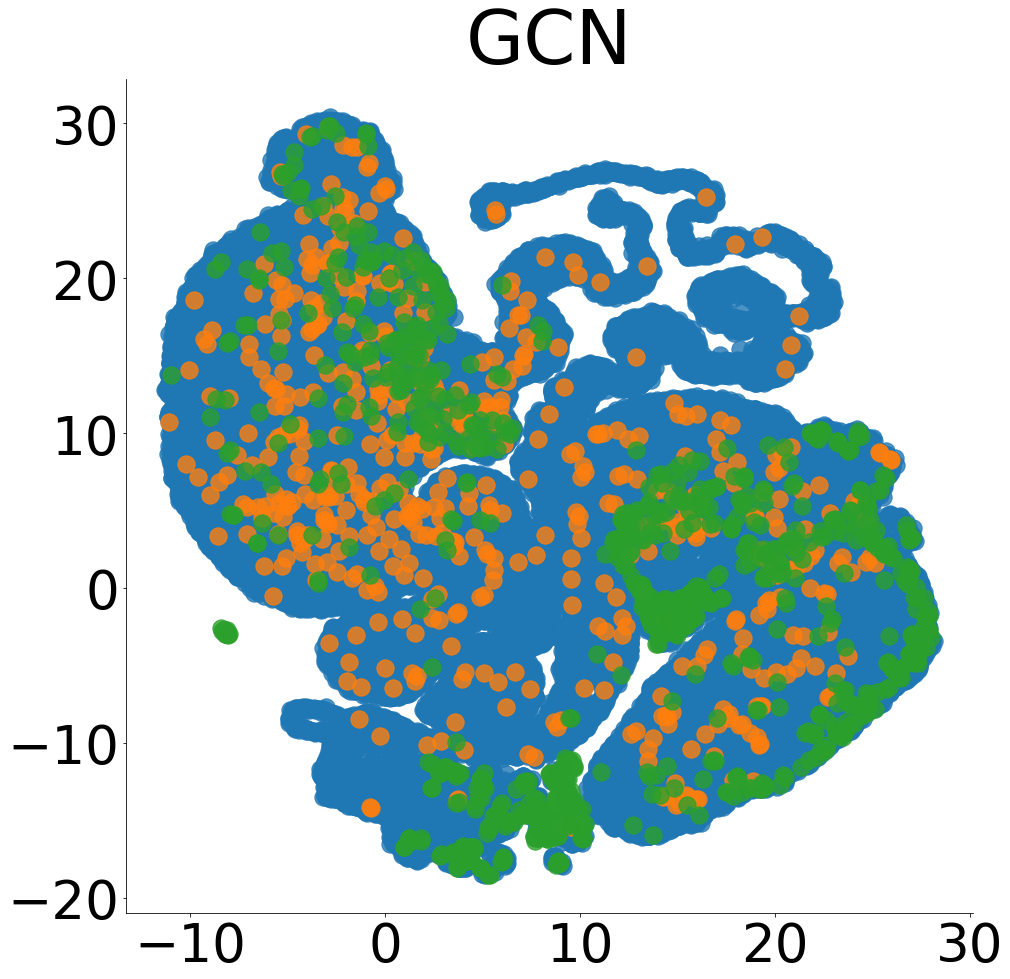

Save the plot ../checkpoints/GCN/split_rs123/umap/org/test_gcn.svg


In [276]:
legend_info = deepcopy(label_map)
ds_name = 'GCN'
split_rs = '123'
umap_folder = f'../checkpoints/{ds_name}/split_rs{split_rs}/umap'
aly_test_umap = AlyUMAP(feat=glstm_x, label=glstm_y[:,0], subset='test', save_folder=f'{umap_folder}/org')
aly_test_umap.generate_umap(overwrite=False)
aly_test_umap.plot()

In [119]:
len(glstm_x)

94224

In [80]:
org_x = np.random.rand(len(glstm_x),16)

test is done.
   label   t-SNE-1   t-SNE-2
0    0.0  4.663163  5.196516
1    0.0  3.998732  5.921654
2    0.0  6.753441  5.801308
3    0.0  4.513588  7.393062
4    0.0  5.568153  7.044492
('2.0', '1.0', '0.0')


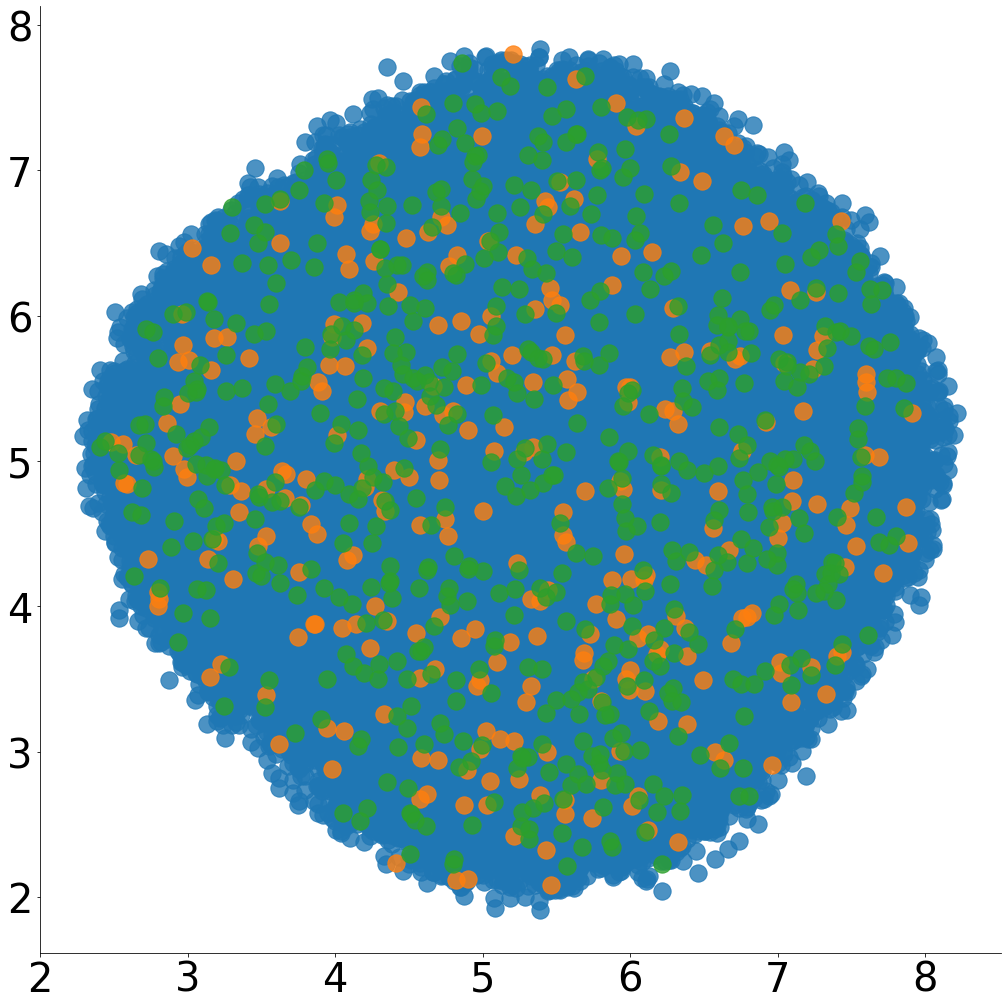

Save the plot ../checkpoints/ddf_resp/split_rs123/models_norm_input2/tsne/org/test_ARITB_ARI.svg


In [81]:
legend_info = deepcopy(label_map)
ds_name = 'ddf_resp'
split_rs = '123'
tsne_folder = f'../checkpoints/{ds_name}/split_rs{split_rs}/models_norm_input2/tsne'
aly_test_tsne = AlyUMAP(feat=org_x, label=glstm_y[:,0], subset='test', save_folder=f'{tsne_folder}/org')
aly_test_tsne.generate_tsne(overwrite=False)
aly_test_tsne.plot()